In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import re
import warnings

     ID     entity sentiment                         Tweet content
0  8026  Microsoft  Positive    The new Microsoft Edge is a beauty
1  8026  Microsoft  Positive    The new Microsoft Edge is a beauty
2  8026  Microsoft  Positive      The New Microsoft Edge Is Beauty
3  8026  Microsoft  Positive  The final Microsoft Edge is a beauty
4  8026  Microsoft  Positive  The new Microsoft Edge 2 is a beauty
Распределение по тональностям (train):
sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64
Процентное соотношение:
 sentiment
Negative      30.183980
Positive      27.894272
Neutral       24.527999
Irrelevant    17.393749
Name: count, dtype: float64


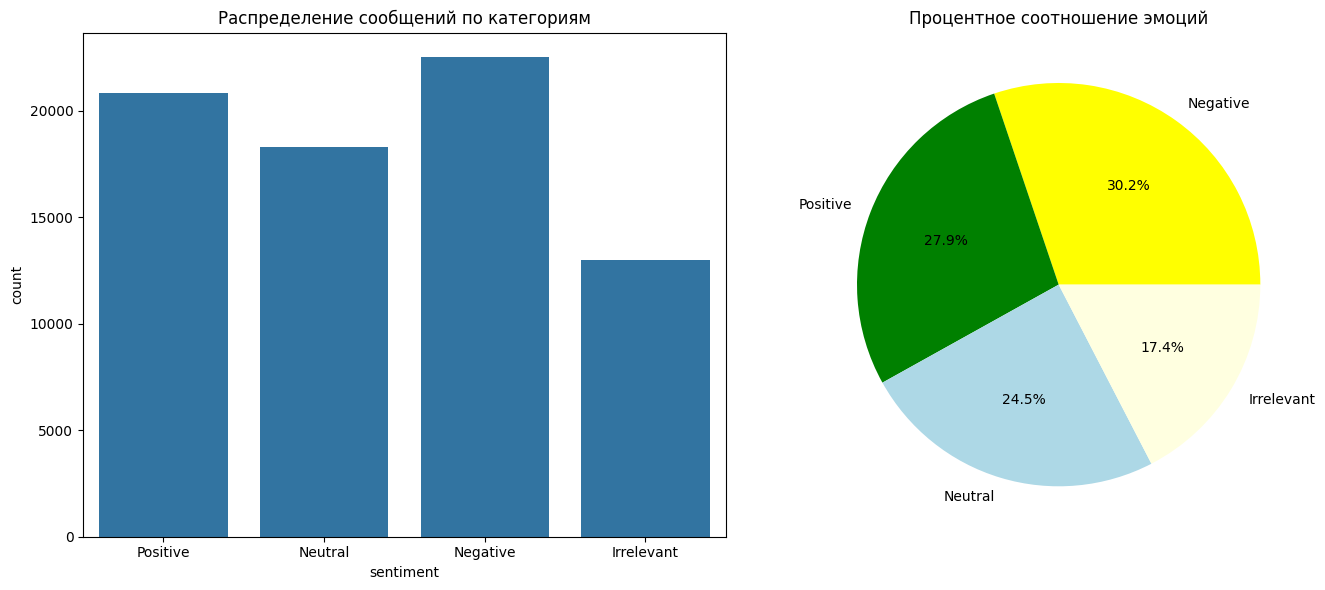

In [2]:
# Загрузка данных
df_train = pd.read_csv('twitter_training.csv', header=None)
df_val = pd.read_csv('twitter_validation.csv', header=None)

# Назначение имен колонкам
df_train.columns = ['ID', 'entity', 'sentiment', 'Tweet content']
df_val.columns = ['ID', 'entity', 'sentiment', 'Tweet content']

# Проверка
print(df_train.head())

# Распределение по классам
print("Распределение по тональностям (train):")
print(df_train['sentiment'].value_counts())

# Расчет процентного соотношения
counts = df_train['sentiment'].value_counts()
percentages = counts / len(df_train) * 100
print("Процентное соотношение:\n", percentages)

# Визуализация: два графика рядом
plt.figure(figsize=(14, 6))

# Первый график: barplot
plt.subplot(1, 2, 1)
sns.countplot(x='sentiment', data=df_train)
plt.title('Распределение сообщений по категориям')

# Второй график: круговая диаграмма
plt.subplot(1, 2, 2)
colors = ['yellow', 'green', 'lightblue', 'lightyellow']
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Процентное соотношение эмоций')

plt.tight_layout()
plt.show()

Обработка тренировочного датасета:
ID                 0
entity             0
sentiment          0
Tweet content    686
dtype: int64
Удалено пропущенных строк: 686
Удалено дубликатов: 2340

Обработка validation датасета:
ID               0
entity           0
sentiment        0
Tweet content    0
dtype: int64
Удалено пропущенных строк: 0
Удалено дубликатов: 0


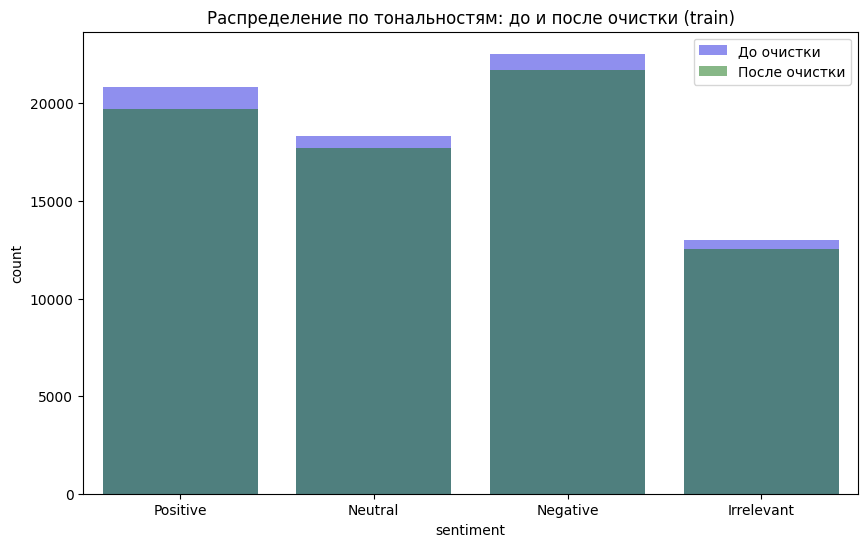


Общее количество сообщений до очистки: 74682
Общее количество сообщений после очистки: 71656
Удалено сообщений: 3026


In [3]:
#Очистка данных
def clean_text(text):
    # Удаление лишних пробелов и специальных символов
    text = re.sub(r'\s+', ' ', str(text))
    text = re.sub(r'[^\w\s.,!?]', '', text)
    return text

# Для тренировочного датасета
print("Обработка тренировочного датасета:")
# Проверка пропусков
print(df_train.isnull().sum())

# Удаление пропусков
initial_len_train = len(df_train)
df_train_clean = df_train.dropna()
print(f"Удалено пропущенных строк: {initial_len_train - len(df_train_clean)}")

# Удаление дубликатов
initial_len_train = len(df_train_clean)
df_train_clean = df_train_clean.drop_duplicates()
print(f"Удалено дубликатов: {initial_len_train - len(df_train_clean)}")

# Приведение текста к нижнему регистру
df_train_clean['Tweet content'] = df_train_clean['Tweet content'].str.lower()

# Очистка текста
df_train_clean['Tweet content'] = df_train_clean['Tweet content'].apply(clean_text)

# Аналогично для validation
print("\nОбработка validation датасета:")
print(df_val.isnull().sum())
initial_len_val = len(df_val)
df_val_clean = df_val.dropna()
print(f"Удалено пропущенных строк: {initial_len_val - len(df_val_clean)}")
initial_len_val = len(df_val_clean)
df_val_clean = df_val_clean.drop_duplicates()
print(f"Удалено дубликатов: {initial_len_val - len(df_val_clean)}")
df_val_clean['Tweet content'] = df_val_clean['Tweet content'].str.lower()
df_val_clean['Tweet content'] = df_val_clean['Tweet content'].apply(clean_text)

# Визуализация распределения до и после очистки для тренировочного датасета
plt.figure(figsize=(10,6))
sns.countplot(x='sentiment', data=df_train, color='blue', alpha=0.5, label='До очистки')
sns.countplot(x='sentiment', data=df_train_clean, color='green', alpha=0.5, label='После очистки')
plt.title('Распределение по тональностям: до и после очистки (train)')
plt.legend()
plt.show()

# Количество сообщений до и после
print(f"\nОбщее количество сообщений до очистки: {len(df_train)}")
print(f"Общее количество сообщений после очистки: {len(df_train_clean)}")
print(f"Удалено сообщений: {len(df_train) - len(df_train_clean)}")

In [6]:
warnings.filterwarnings("ignore")
#Создание простой модели
# Размер словаря и последовательности
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100

# 1. Токенизация текста
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df_train_clean['Tweet content'])

X_train_sequences = tokenizer.texts_to_sequences(df_train_clean['Tweet content'])
X_train = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# 2. Кодирование меток
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(df_train_clean['sentiment'])

# Для многоклассовой классификации
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes=num_classes)

# Аналогично для валидационных данных
X_val_sequences = tokenizer.texts_to_sequences(df_val_clean['Tweet content'])
X_val = pad_sequences(X_val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
y_val_encoded = label_encoder.transform(df_val_clean['sentiment'])
y_val = to_categorical(y_val_encoded, num_classes=num_classes)

# 3. Создание модели
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=64, input_length=MAX_SEQUENCE_LENGTH))
model.add(GlobalAveragePooling1D())
# Первый скрытый слой
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
# Второй скрытый слой
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
# Выходной слой
model.add(Dense(num_classes, activation='softmax'))

# 4. Компиляция
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 5. Обучение
history = model.fit(X_train, y_train, epochs=30, batch_size=512, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.2701 - loss: 1.3808 - val_accuracy: 0.2660 - val_loss: 1.3728
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.3065 - loss: 1.3678 - val_accuracy: 0.2660 - val_loss: 1.3721
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.3017 - loss: 1.3645 - val_accuracy: 0.2660 - val_loss: 1.3638
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.3056 - loss: 1.3546 - val_accuracy: 0.3140 - val_loss: 1.3187
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.3776 - loss: 1.3086 - val_accuracy: 0.4010 - val_loss: 1.2576
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.4246 - loss: 1.2551 - val_accuracy: 0.4300 - val_loss: 1.2103
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4397 - loss: 1.2194 - val_accuracy: 0.4150 - val_loss: 1.1904
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4478 - loss: 1.1939 - val_accu

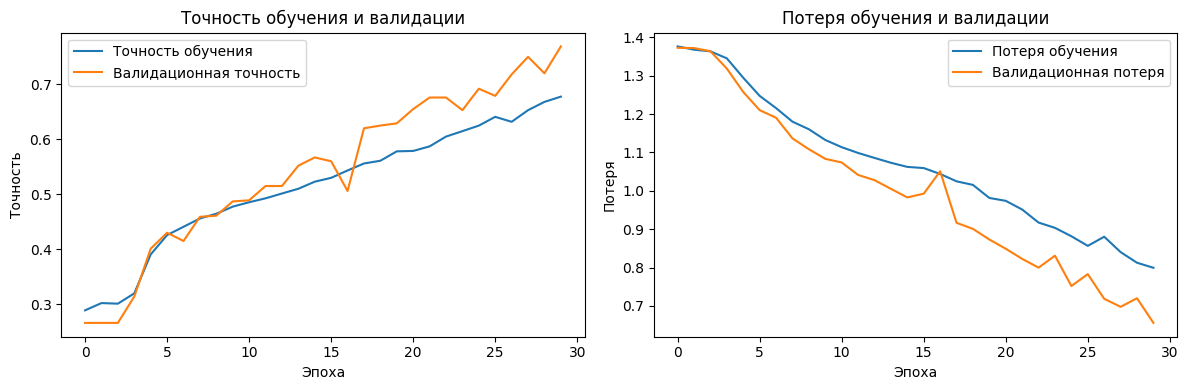

In [7]:
# Построение графиков
def plot_training_history(history):
    # График точности
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Точность обучения')
    plt.plot(history.history['val_accuracy'], label='Валидационная точность')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.title('Точность обучения и валидации')

    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Потеря обучения')
    plt.plot(history.history['val_loss'], label='Валидационная потеря')
    plt.xlabel('Эпоха')
    plt.ylabel('Потеря')
    plt.legend()
    plt.title('Потеря обучения и валидации')

    plt.tight_layout()
    plt.show()

# Вызов функции после обучения
plot_training_history(history)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


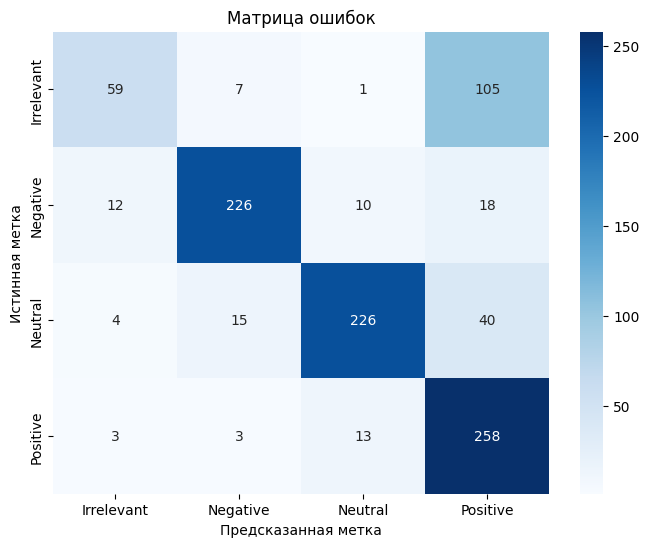

In [8]:
# Предсказания на валидационной выборке
y_pred_probs = model.predict(X_val)
# Получаем метки классов
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Построение матрицы ошибок
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Визуализация
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Предсказанная метка')
plt.ylabel('Истинная метка')
plt.title('Матрица ошибок')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


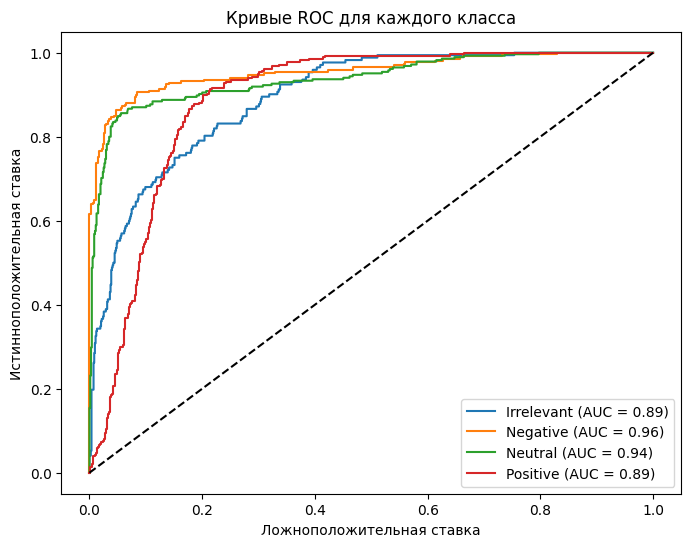

In [9]:
# Предсказания вероятностей
y_pred_probs = model.predict(X_val)

# Построение ROC для каждого класса
plt.figure(figsize=(8,6))
for i, class_label in enumerate(label_encoder.classes_):
    fpr, tpr, thresholds = roc_curve(y_val[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # диагональ
plt.xlabel('Ложноположительная ставка')
plt.ylabel('Истинноположительная ставка')
plt.title('Кривые ROC для каждого класса')
plt.legend()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


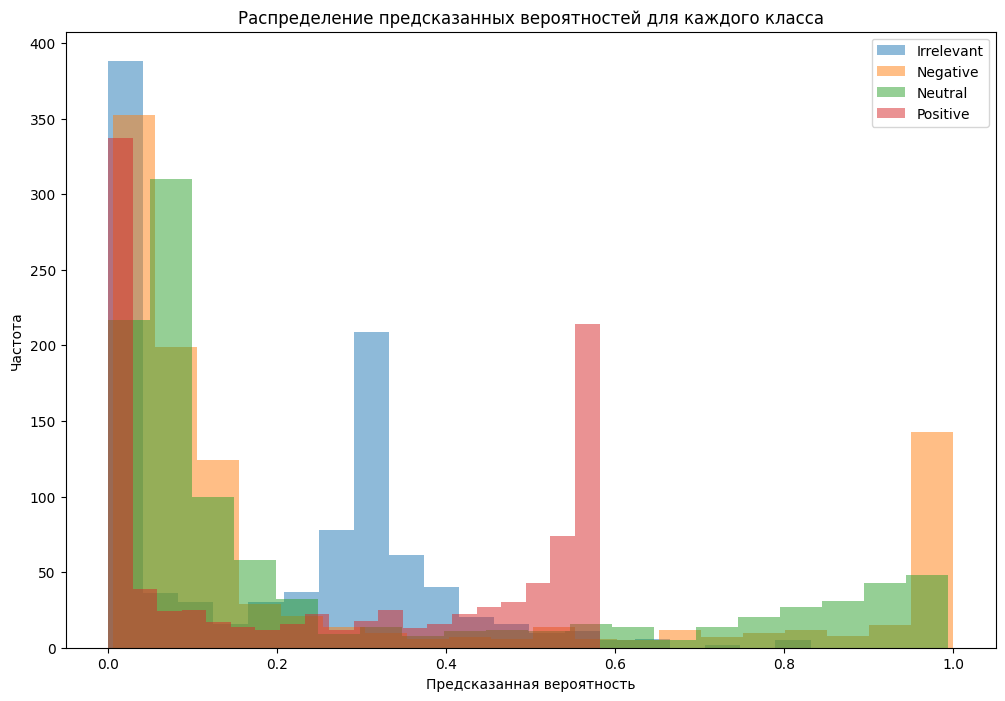

In [10]:
# Предсказания вероятностей для всех данных
probas = model.predict(X_val)

# Построим гистограммы для каждого класса
plt.figure(figsize=(12, 8))
num_classes = len(label_encoder.classes_)

for i in range(num_classes):
    plt.hist(probas[:, i], bins=20, alpha=0.5, label=f'{label_encoder.classes_[i]}')

plt.xlabel('Предсказанная вероятность')
plt.ylabel('Частота')
plt.title('Распределение предсказанных вероятностей для каждого класса')
plt.legend()
plt.show()

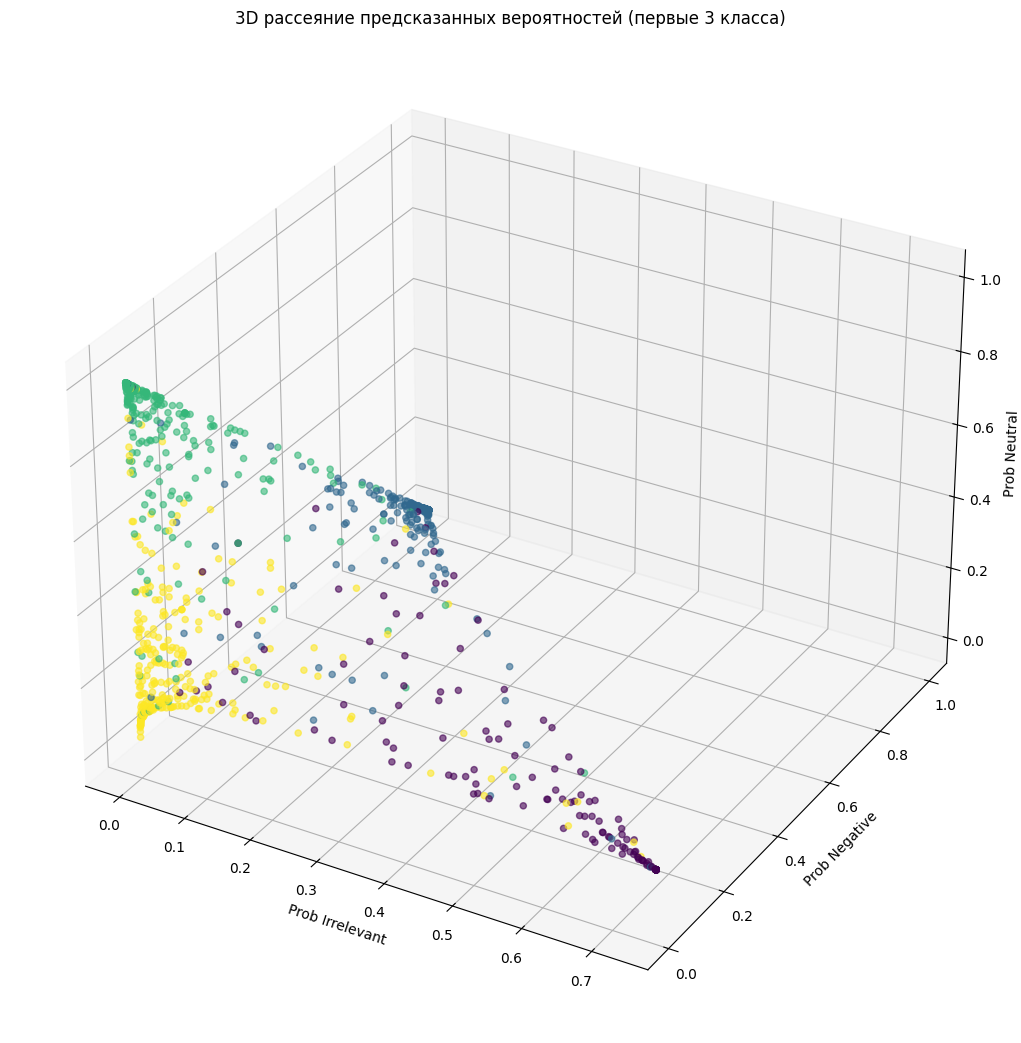

In [11]:
fig = plt.figure(figsize=(15,13))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(probas[:,0], probas[:,1], probas[:,2], c=y_true_classes, cmap='viridis', alpha=0.6)

ax.set_xlabel(f'Prob {label_encoder.classes_[0]}')
ax.set_ylabel(f'Prob {label_encoder.classes_[1]}')
ax.set_zlabel(f'Prob {label_encoder.classes_[2]}')

plt.title('3D рассеяние предсказанных вероятностей (первые 3 класса)')
plt.show()

In [12]:
def preprocess_text(text):
    return re.sub(r'[^\w\s.,!?]', '', re.sub(r'\s+', ' ', str(text)).lower())

def predict_sentiment(text):
    seq = pad_sequences(tokenizer.texts_to_sequences([preprocess_text(text)]), maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(seq)[0]
    idx = np.argmax(pred)
    label = label_encoder.inverse_transform([idx])[0]
    return label, pred[idx]

user_input = input("Введите сообщение для анализа: ")
print(f"Сообщение: {user_input}")
sentiment, confidence = predict_sentiment(user_input)
print(f"Тональность: {sentiment} (уверенность: {confidence:.2f})")

Сообщение: you are bad kitty
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Тональность: Negative (уверенность: 0.64)


Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.2965 - loss: 1.3717 - val_accuracy: 0.2690 - val_loss: 1.3558
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.3728 - loss: 1.3137 - val_accuracy: 0.5570 - val_loss: 1.1522
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.4926 - loss: 1.1658 - val_accuracy: 0.6210 - val_loss: 0.9792
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.5823 - loss: 1.0150 - val_accuracy: 0.7090 - val_loss: 0.7862
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.6495 - loss: 0.8931 - val_accuracy: 0.7600 - val_loss: 0.7053
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6675 - loss: 0.8505 - val_accuracy: 0.7260 - val_loss: 0.6897
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.6907 - loss: 0.7963 - val_accuracy: 0.7870 - val_loss: 0.5862
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7010 - loss: 0.7719 - val_acc

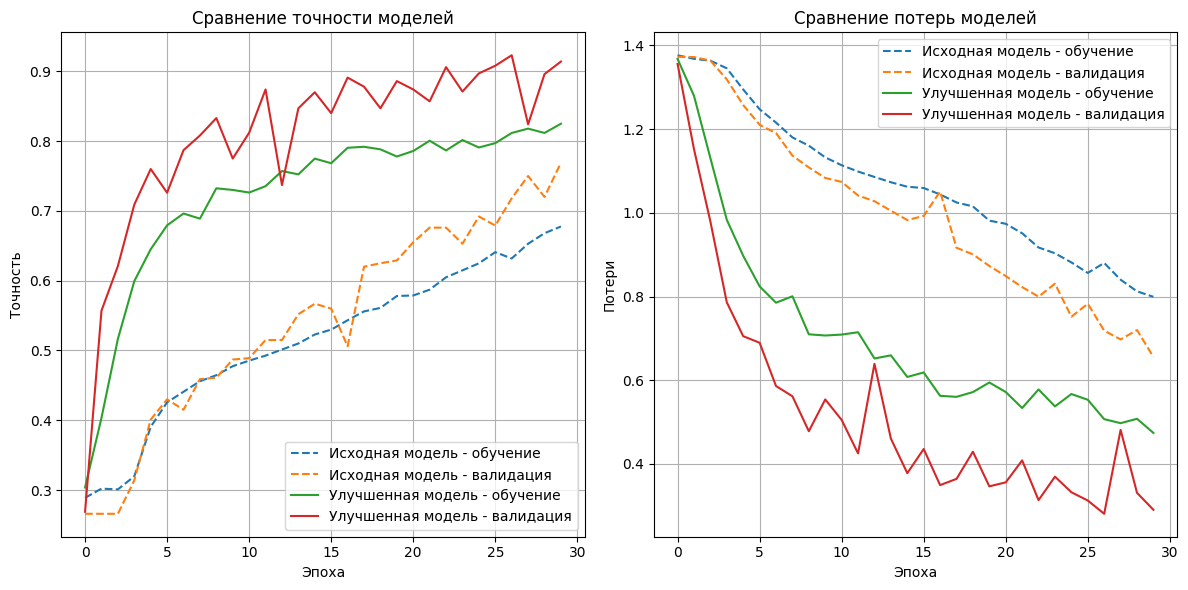

In [15]:
# Построим улучшенную модель
improved_model = Sequential()
improved_model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=64, input_length=MAX_SEQUENCE_LENGTH))
improved_model.add(GlobalAveragePooling1D())
improved_model.add(Dense(64, activation='relu'))
improved_model.add(Dropout(0.3))
improved_model.add(Dense(64, activation='relu'))
improved_model.add(Dropout(0.3))
improved_model.add(Dense(num_classes, activation='softmax'))

improved_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Обучение улучшенной модели
history_improved = improved_model.fit(X_train, y_train, epochs=30, batch_size=512, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Оценка
loss1, acc1 = model.evaluate(X_train, y_train, verbose=0)
loss2, acc2 = improved_model.evaluate(X_train, y_train, verbose=0)

print(f"Точность первой модели: {acc1:.4f}")
print(f"Точность улучшенной модели: {acc2:.4f}")


# Построение графиков сравнения
plt.figure(figsize=(12, 6))
# Точность
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], linestyle='--', label='Исходная модель - обучение')
plt.plot(history.history['val_accuracy'], linestyle='--', label='Исходная модель - валидация')
plt.plot(history_improved.history['accuracy'], label='Улучшенная модель - обучение')
plt.plot(history_improved.history['val_accuracy'], label='Улучшенная модель - валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Сравнение точности моделей')
plt.legend()
plt.grid(True)

# Потери
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], linestyle='--', label='Исходная модель - обучение')
plt.plot(history.history['val_loss'], linestyle='--', label='Исходная модель - валидация')
plt.plot(history_improved.history['loss'], label='Улучшенная модель - обучение')
plt.plot(history_improved.history['val_loss'], label='Улучшенная модель - валидация')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Сравнение потерь моделей')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
def preprocess_text(text):
    return re.sub(r'[^\w\s.,!?]', '', re.sub(r'\s+', ' ', str(text)).lower())

def predict_sentiment(text):
    seq = pad_sequences(tokenizer.texts_to_sequences([preprocess_text(text)]), maxlen=MAX_SEQUENCE_LENGTH)
    pred = improved_model.predict(seq)[0]
    idx = np.argmax(pred)
    label = label_encoder.inverse_transform([idx])[0]
    return label, pred[idx]

user_input = input("Введите сообщение для анализа: ")
print(f"Сообщение: {user_input}")
sentiment, confidence = predict_sentiment(user_input)
print(f"Тональность: {sentiment} (уверенность: {confidence:.2f})")

Сообщение: you are bad kitty
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Тональность: Negative (уверенность: 0.78)
